# Plots for the Clustering Paper

This notebook contains all the plots made for the clustering paper.

In [1]:
from spore.mock.mock_ps_foregrounds import visibility_covariance, PoissonProcessForegrounds, ClusteredForegroundsOnly, ClusteredForegrounds,PowerLawSourceCounts, CircularGaussian
from spore.model.foregrounds import PointSourceCircularGaussian, CircularGaussianPowerLaw
from spore.model.source_counts import MultiPowerLawSourceCounts
from spore.visualise.power_spectra import plot_2D_PS, plot_2D_PS_compare, plot_2D_PS_ratio_diff, plot_2D_PS_frac_tot, plot_sig_to_noise_compare
from spore.measure import power_spectra_from_sim_direct as pssim, unit_conversions as uc
from spore.measure.ps_2d_from_single_vis import power_spec_from_visibility
from spore.mock.convert_sim_to_vis import get_sim_21cmfast, sim_to_vis
from spore.mock.tocm_tools import readbox

from astropy.cosmology import Planck15
from astropy import units as un
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
%matplotlib inline

import numpy as np

import cPickle as pickle

from scipy.stats import norm
from scipy.special import i0,gamma,factorial,  hyp1f1
from scipy.integrate import simps
from scipy.signal import blackmanharris
from scipy.interpolate import InterpolatedUnivariateSpline as spline, griddata

from powerbox.tools import angular_average, get_power
from powerbox.dft import fft
from powerbox.powerbox import _magnitude_grid

import tqdm

In [48]:
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.size'] = 13
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 13


## Source Count Model

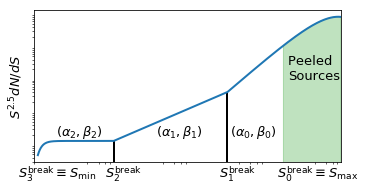

In [52]:
plt.figure(figsize=(5.5,2.8))
sc = MultiPowerLawSourceCounts(Smax0=1.,Smin0=1e-8,alpha=4100,beta=[1.5,2.,2.5],Sbreak=[1e-3,1e-6])
s = np.logspace(-8,0,1000)[:-1]
dn = sc.dnds(s)
dn *= np.exp(-(1e-8/s)**4)
dn *= np.exp(-(2*s)**0.7)

dn *= s**2.5
plt.plot(s, dn)
plt.xscale('log')
plt.yscale('log')
# plt.gca().axes.get_xaxis().set_ticks([])
# plt.gca().axes.get_yaxis().set_ticks([])
plt.tick_params(axis='both', left='off', top='off', right='off', bottom='off',labelleft='off', labeltop='off', labelright='off', labelbottom='off')

plt.vlines([1e-6,1e-3],[0,0],[sc.dnds(1e-6)*1e-15,sc.dnds(1e-3)*10**-7.5])
plt.fill_between(s[s>=3e-2], dn[s>=3e-2],color='C2',alpha=0.3)

plt.text(4e-2,1e1,"Peeled \nSources")
plt.text(2e-2,1.e-2,r"$S^{\rm break}_0 \equiv S_{\rm max}$")
plt.text(0.6e-3,1.e-2, r"$S^{\rm break}_1$")
plt.text(0.6e-6,1.e-2, r"$S^{\rm break}_2$")
plt.text(0.3e-8,1.e-2,r"$S^{\rm break}_3 \equiv S_{\rm min}$")

plt.text(1.2e-3,2e-1,r"$(\alpha_0,\beta_0)$")
plt.text(1.3e-5,2e-1,r"$(\alpha_1,\beta_1)$")
plt.text(3e-8,2e-1,r"$(\alpha_2,\beta_2)$")

#plt.xlabel("$\log S$ [Arbitrary Units]")
plt.ylabel("$S^{2.5} dN/dS$")

plt.xlim(0.8e-8,1)

plt.savefig("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/figures/source_count_schematic.pdf")

## Testing Separability of Poisson/Clustering

In [43]:
u0 = 0.02
kappa = 1.5

nu1 = 1.25
nu2 = 1.5

sc = PowerLawSourceCounts(nu=[1.,nu1,nu2],Smax0=1e0,Smin0=1e-1,alpha=6998.,beta=1.54)

cf = ClusteredForegrounds(point_source_power_spec=lambda u : (u/u0)**-kappa,
                          use_lognormal=True,
                          source_counts=sc, 
                          beam_model=CircularGaussian(150.,nu=[1.,nu1,nu2]),
                          sky_size=4, ncells=256,seed=1234)

cof = ClusteredForegroundsOnly(point_source_power_spec=lambda u : (u/u0)**-kappa,
                                  use_lognormal=True,
                                  source_counts=sc, 
                                  beam_model=CircularGaussian(150.,nu=[1.,nu1,nu2]),
                                  sky_size=4, ncells=256,seed=1234)

pf = PoissonProcessForegrounds(source_counts=sc, 
                               beam_model=CircularGaussian(150.,nu=[1.,nu1,nu2]),
                               sky_size=4, ncells=256,seed=1234)


model = CircularGaussianPowerLaw(source_counts=cf.source_counts,
                                  beam_model=cf.beam_model,
                                  u =np.logspace(0,1.8,50),
                                  clustering_params={"u0":u0,"kappa":kappa})

# a,b = 0,2*np.pi
# ubins, vis_covar = visibility_covariance(foreground_model=cf.__class__,
#                                        niter=200, seed=cf.seed,
#                                        point_source_power_spec=cf.point_source_power_spec,
#                                        use_lognormal=True,
#                                        source_counts=cf.source_counts, 
#                                        beam_model=cf.beam_model,
#                                        sky_size=4, ncells=cf.ncells,
#                                         a=a,b=b)

# ubins, vis_covar_only = visibility_covariance(foreground_model=cof.__class__,
#                                        niter=200, seed=cof.seed,
#                                        point_source_power_spec=cof.point_source_power_spec,
#                                        use_lognormal=True,
#                                        source_counts=cof.source_counts, 
#                                        beam_model=cof.beam_model,
#                                        sky_size=4, ncells=cof.ncells,
#                                               a=a,b=b)

# ubins, vis_covar_pf = visibility_covariance(foreground_model=pf.__class__,
#                                        niter=200, seed=pf.seed,
#                                        source_counts=pf.source_counts, 
#                                        beam_model=pf.beam_model,
#                                        sky_size=4, ncells=pf.ncells,
#                                             a=a,b=b)

In [42]:
import pickle

try:
    vis_covar
    with open("all_my_data_u.pkl",'w') as f:
        pickle.dump({"ubins":ubins,"vis_covar":vis_covar,"vis_covar_only":vis_covar_only,"vis_covar_pf":vis_covar_pf},f)

except NameError:
    with open("all_my_data_u.pkl",'r') as f:
        d = pickle.load(f)
        ubins = d['ubins']
        vis_covar = d['vis_covar']
        vis_covar_only = d['vis_covar_only']
        vis_covar_pf = d['vis_covar_pf']
 

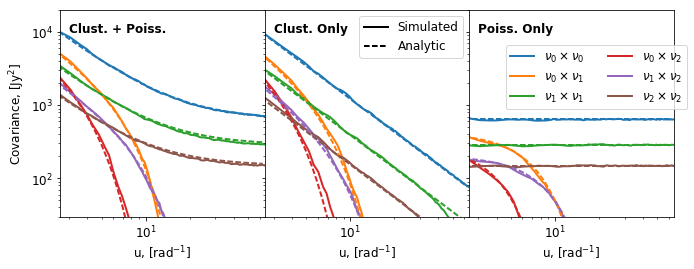

In [74]:
fig, ax = plt.subplots(1,3, figsize=(11,3.8),sharex=True,sharey=True,
                       gridspec_kw={"hspace":0,'wspace':0},
                       subplot_kw={"xscale":"log","yscale":'log',"ylim":(30,2e4),"xlim":(2.6,65)})

mpl.rcParams['font.size'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

# Generate legend entries
ax[1].plot([0],[0],color="k",label="Simulated")
ax[1].plot([0],[0],color="k",ls='--',label="Analytic")

ax[0].plot(ubins,vis_covar[0,0],color="C0")
ax[0].plot(ubins,vis_covar[0,1],color="C1")
ax[0].plot(ubins,vis_covar[1,1],color="C2")
ax[0].plot(ubins,vis_covar[0,2],color="C3")
ax[0].plot(ubins,vis_covar[1,2],color="C4")
ax[0].plot(ubins,vis_covar[2,2],color="C5")

ax[1].plot(ubins,vis_covar_only[0,0],color="C0")
ax[1].plot(ubins,vis_covar_only[0,1],color="C1")
ax[1].plot(ubins,vis_covar_only[1,1],color="C2")
ax[1].plot(ubins,vis_covar_only[0,2],color="C3")
ax[1].plot(ubins,vis_covar_only[1,2],color="C4")
ax[1].plot(ubins,vis_covar_only[2,2],color="C5")

ax[2].plot(ubins,vis_covar_pf[0,0],label=r"$\nu_0 \times \nu_0$",color="C0")
ax[2].plot(ubins,vis_covar_pf[0,1],label=r"$\nu_0 \times \nu_1$",color="C1")
ax[2].plot(ubins,vis_covar_pf[1,1],label=r"$\nu_1 \times \nu_1$",color="C2")
ax[2].plot(ubins,vis_covar_pf[0,2],label=r"$\nu_0 \times \nu_2$",color="C3")
ax[2].plot(ubins,vis_covar_pf[1,2],label=r"$\nu_1 \times \nu_2$",color="C4")
ax[2].plot(ubins,vis_covar_pf[2,2],label=r"$\nu_2 \times \nu_2$",color="C5")


# ax[1].plot(model.u,res_anl,lw=5,color="C8")
# ax[1].plot(model.u,res,lw=5,color="C7",ls=':')


ax[0].plot(model.u,model.total_covariance[:,0,0],color="C0",ls='--')
ax[0].plot(model.u,model.total_covariance[:,0,1],color="C1",ls="--")
ax[0].plot(model.u,model.total_covariance[:,1,1],color="C2",ls='--')
ax[0].plot(model.u,model.total_covariance[:,0,2],color="C3",ls='--')
ax[0].plot(model.u,model.total_covariance[:,1,2],color="C4",ls="--")
ax[0].plot(model.u,model.total_covariance[:,2,2],color="C5",ls='--')

fac =1
ax[1].plot(model.u,model.clustered_only_covariance[:,0,0]*fac,color="C0",ls='--')
ax[1].plot(model.u,model.clustered_only_covariance[:,0,1]*fac,color="C1",ls="--")
ax[1].plot(model.u,model.clustered_only_covariance[:,1,1]*fac,color="C2",ls='--')
ax[1].plot(model.u,model.clustered_only_covariance[:,0,2]*fac,color="C3",ls='--')
ax[1].plot(model.u,model.clustered_only_covariance[:,1,2]*fac,color="C4",ls="--")
ax[1].plot(model.u,model.clustered_only_covariance[:,2,2]*fac,color="C5",ls='--')

ax[2].plot(model.u,model.poisson_covariance[:,0,0],color="C0",ls='--')
ax[2].plot(model.u,model.poisson_covariance[:,0,1],color="C1",ls="--")
ax[2].plot(model.u,model.poisson_covariance[:,1,1],color="C2",ls='--')
ax[2].plot(model.u,model.poisson_covariance[:,0,2],color="C3",ls='--')
ax[2].plot(model.u,model.poisson_covariance[:,1,2],color="C4",ls="--")
ax[2].plot(model.u,model.poisson_covariance[:,2,2],color="C5",ls='--')

ax[0].set_xlabel(r"u, [${\rm rad}^{-1}$]")
ax[1].set_xlabel(r"u, [${\rm rad}^{-1}$]")
ax[2].set_xlabel(r"u, [${\rm rad}^{-1}$]")
ax[0].set_ylabel(r"Covariance, [${\rm Jy}^2$]")

ax[0].text(3,10000,"Clust. + Poiss.", fontweight="bold")
ax[1].text(3,10000,"Clust. Only",fontweight='bold')
ax[2].text(3,10000,"Poiss. Only",fontweight='bold')

ax[1].legend()
ax[2].legend(ncol=2,bbox_to_anchor=(0.68, 0.495),
           bbox_transform=plt.gcf().transFigure)

fig.savefig("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/figures/compare_clustering_only.pdf")

Covariance between frequency channels of visibilities including only point sources. Only two frequency channels are shown for clarity, and these are exaggerated. The reference frequency ``$\nu_0$`` = {{model.beam_model.nu0}}Mhz, and the displayed frequencies are ``$f_0 = (``{{model.nu[0]}},{{model.nu[1]}}, {{model.nu[2]}}``)$``. The box-size of the simulation is four times the FWHM of the beam, at {{"%1.2f"%cf.sky_size[0]}}, with {{cf.ncells}} grid cells per side, and 200 realisations were used in order to generate the covariance. The power-law power spectrum has ``$(\omega_0,\kappa)=({{u0}},{{kappa}})$``. Blue, green and brown lines indicate variances at each frequency as a function of the perpendicular scale ``$u$``, while the orange, purple and maroon lines indicate covariances between the frequencies. Solid lines show fully simulated results, while dashed lines show the result of Eq. ``\ref{eq:general_clustering_covariance}``. The LHS panel shows the results of the full covariance, with both clustering and Poisson scatter present, while the centre and RHS panels show the results with just clustering and Poisson terms respectively. Eq. ``\ref{eq:general_clustering_covariance}`` assumes these stochastic effects can be separated, and the LHS panel confirms the validity of this assumption, revealing no significant departure of the simulation from the model. The primary effect of including Poisson scatter is to add a constant to the variances, to which the solutions asymptote.

## Testing Assumption of Gaussianity

In [21]:
def test_gaussianity():
    u0 = 0.02
    kappa = 1.5
    sc = PowerLawSourceCounts(nu=[1.,1.2],Smax0=1e0,Smin0=1e-1,alpha=6998.,beta=1.54)


    model = [0]*4
    vis_covar = [0]*4
    cf = [0]*4
    deltax = [0]*4
    for i in range(4):
        print u0*(2**i)
        cf[i] = ClusteredForegrounds(point_source_power_spec=lambda u : (u/(u0*(2**i)))**-kappa,
                                  use_lognormal=True,
                                  source_counts=sc, 
                                  beam_model=CircularGaussian(150.,nu=[1.,1.2]),
                                  sky_size=4, ncells=256,seed=1234)
        deltax[i] = cf[i].powerbox.delta_x()
        
        model[i] = CircularGaussianPowerLaw(source_counts=cf[i].source_counts,
                                          beam_model=cf[i].beam_model,
                                          u =np.logspace(-1,2,50),
                                          clustering_params={"u0":u0*(2**i),"kappa":kappa})

        ubins, vis_covar[i] = visibility_covariance(foreground_model=cf[i].__class__,
                                               niter=50, seed=cf[i].seed,
                                               point_source_power_spec=cf[i].point_source_power_spec,
                                               use_lognormal=True,
                                               source_counts=cf[i].source_counts, 
                                               beam_model=cf[i].beam_model,
                                               sky_size=4, ncells=cf[i].ncells,
                                                   a=0,b=2*np.pi)
    return ubins, vis_covar, model, cf, deltax
    
tg_ubins, tg_vis_covar, tg_model, tg_cf,tg_delx = test_gaussianity()

0.02


/home/steven/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in power


0.04
0.08
0.16


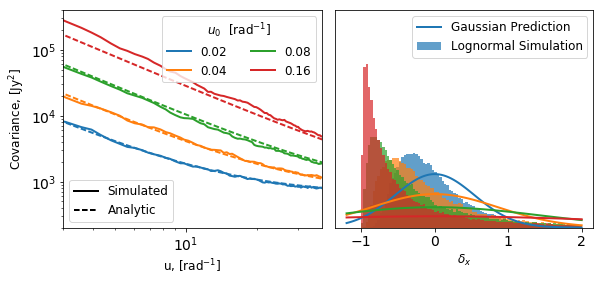

In [87]:
fig,ax = plt.subplots(1,2,figsize=(9.5,4),gridspec_kw={"wspace":0.05})


mpl.rcParams['font.size'] = 12
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

labels = [0]*len(tg_model)
for i,(vc, mod,cf_,delx) in enumerate(zip(tg_vis_covar, tg_model,tg_cf,tg_delx)):
    
    # Generate legend entries
    
    if i==0:
        line1, = ax[0].plot([0],[0],color="k",label="Simulated")
        line2, = ax[0].plot([0],[0],color="k",ls='--',label="Analytic")

        first_legend = ax[0].legend(handles=[line1,line2], loc=3,fontsize=12)
        ax[0].add_artist(first_legend)

    labels[i], = ax[0].plot(tg_ubins, vc[0,0],color="C%d"%i, label=r"%s"%(mod.clustering_params['u0'].value))
    ax[0].plot(mod.u, mod.total_covariance[:,0,0],color="C%d"%i,ls='--')
    
    #delx = cf_.powerbox.delta_x()
    std = np.std(delx)
    x = np.linspace(-1.2,2,100)
    
    ax[1].hist(delx.flatten(),color="C%d"%i,normed=True, bins =x ,lw=2, label="Lognormal Simulation" if not i else "", alpha=0.7) 
    ax[1].plot(x, norm(scale=std).pdf(x),color="C%d"%i, label="Gaussian Prediction" if not i else "")
    
ax[0].set_xlim((3,38))
ax[0].set_ylim((200,4e5))
ax[0].set_xscale('log')
ax[0].set_yscale('log')


ax[0].set_xlabel(r"u, [${\rm rad}^{-1}$]")
ax[0].set_ylabel(r"Covariance, $[{\rm Jy}^2]$")
ax[1].set_xlabel(r"$\delta_x$")

ax[0].legend(handles = labels,ncol=2, title=r"$u_0 \ \ [\mathrm{rad}^{-1}]$",loc=1)
ax[1].legend()
ax[1].set_ylim(0,3)
ax[1].set_yticks([])

fig.savefig("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/figures/test_lognormal.pdf")
plt.show()

Comparison of model covariance to simulations with varying magnitudes of bin-to-bin variance, ``$\sigma^2$``. The point-source PS has ``$\kappa=$``{{kappa}}, with varying ``$\omega_0$``, as shown by line colour. Model predictions (shown by dashed lines in left-hand panel) are in good agreement for low ``$\omega_0$`` (corresponding to low ``$\sigma^2$``), but start to diverge at high ``$\sigma^2$``. Simulations use a physically viable log-normal over-density distribution (shown in right-hand panel), while the model assumes a Gaussian distribution (for which the pdf with matching ``$\sigma^2$`` is shown as a solid curve in the right-hand panel). The further the underlying distribution strays from Gaussianity, the more inaccurate the model prediction. Realistic sky distributions will tend to be close to Gaussian.

## Comparison of Source Count Parameters

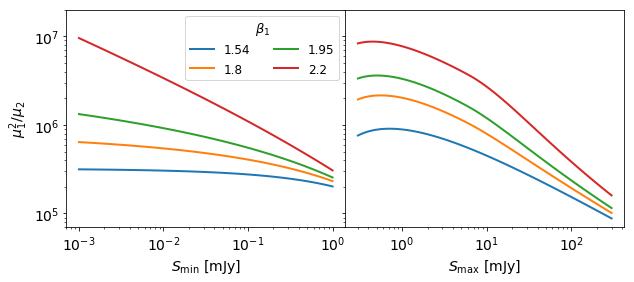

In [89]:
def mu1_over_mu2(Smin,Smax,beta):
    sc = MultiPowerLawSourceCounts(Smax0=Smax,Smin0=Smin,alpha=6998,Sbreak=[0.006],beta=beta)
    return (sc.total_flux_density**2/sc.total_squared_flux_density).flatten()

fig,ax = plt.subplots(1,2,figsize=(10,4),sharey=True,subplot_kw={"xscale":'log','yscale':'log'}, gridspec_kw={"hspace":0,'wspace':0})

fac = np.logspace(-2,1,100)
SMIN = 1e-4
SMAX = 3e-2
beta = [1.54,1.8,1.95,2.2]

for j,b in enumerate(beta):
    res = [0]*len(fac)
    for i,f in enumerate(fac):
        res[i] = mu1_over_mu2(f*SMIN,SMAX,[1.54,b])
        
    ax[0].plot(1e3 *fac*SMIN,res,color="C%s"%j,label=str(b))
    
    res = [0]*len(fac)
    for i,f in enumerate(fac):
        res[i] = mu1_over_mu2(SMIN,f*SMAX,[1.54,b])
    
    ax[1].plot(1e3 *fac*SMAX,res,color="C%s"%j,lw=2)
    
leg1 = ax[0].legend(ncol=2,title=r"$\beta_1$",fontsize=12)
# ax = plt.gca().add_artist(leg1)
plt.setp(leg1.get_title(), fontsize=13)

# line1, = plt.plot([0],[0],color='k',ls='--',label=r"$S_{\rm min}$")
# line2, = plt.plot([0],[0],color='k',ls='-',label=r"$S_{\rm max}$")
# plt.legend(handles=[line1,line2],loc="upper center",fontsize=15)

#plt.xlim(1e-2,1e1)
plt.ylim(7e4,2e7)

ax[0].set_xlabel(r"$S_{\rm min}$ [mJy]",fontsize=14)
ax[1].set_xlabel(r"$S_{\rm max}$ [mJy]",fontsize=14)

ax[0].set_ylabel(r"$\mu_1^2/\mu_2$",fontsize=14)
plt.savefig("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/figures/source_count_comparison.pdf")

In [92]:
print mu1_over_mu2(1e-4,0.03,[1.54,1.54])**(1/4.5) *1  * 2
print mu1_over_mu2(1e-6,0.001,[1.54,2.2])**(1/1.5) *0.01 * 2

[ 32.36771793] 1 / sr(2/9)
[ 6133.90911984] 1 / sr(2/3)


## Simple Comparison of Power Spectra

1 / sr sr


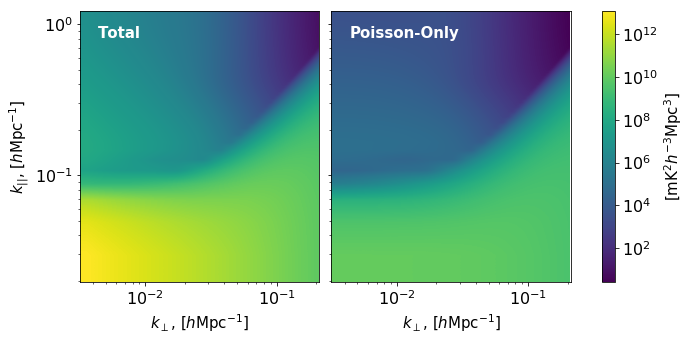

In [31]:
u0 = 0.05
kappa = 1.5

mpl.rcParams['font.size'] = 15
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

nu = np.linspace(1,180./150.,128)

model = CircularGaussianPowerLaw(source_counts=MultiPowerLawSourceCounts(nu=nu,Smax0=0.03,Smin0=1e-4,alpha=6998.,beta=[1.54,1.95],Sbreak=[0.006]), 
                                 beam_model=CircularGaussian(150.,nu=nu),
                                 u =np.linspace(3,200.0,300),
                                 clustering_params={"u0":u0,"kappa":kappa})

total_ps = model.power_cov_total(taper=blackmanharris)
poiss_ps = model.power_cov_poisson(taper=blackmanharris)
plot_2D_PS_compare([[np.sqrt(total_ps)],[np.sqrt(poiss_ps)]],model.kperp,model.kpar,interp="bilinear", plt_labels=[['Total'], ["Poisson-Only"]])
plt.savefig("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/figures/compare_total_poisson_PS.pdf")
plt.show()

## Ratios for different parameter choices

In [32]:
# BASIC PARAMETERS
nu = np.linspace(1,180./150.,128)


# CREATE MODELS
model = CircularGaussianPowerLaw(source_counts=MultiPowerLawSourceCounts(nu=nu,Smax0=0.03,Smin0=1e-4,alpha=6998.,beta=[1.54,1.95],Sbreak=[0.006]), 
                                 beam_model=CircularGaussian(150.,nu=nu),
                                 u =np.linspace(3,200.0,300),
                                 clustering_params={"u0":0.05,"kappa":1.5})
model_slope = CircularGaussianPowerLaw(source_counts=MultiPowerLawSourceCounts(nu=nu,Smax0=0.03,Smin0=1e-4,alpha=6998.,beta=[1.54,1.95],Sbreak=[0.006]), 
                                 beam_model=CircularGaussian(150.,nu=nu),
                                 u =np.linspace(3,200.0,300),
                                 clustering_params={"u0":0.05,"kappa":2.5})
model_u0 = CircularGaussianPowerLaw(source_counts=MultiPowerLawSourceCounts(nu=nu,Smax0=0.03,Smin0=1e-4,alpha=6998.,beta=[1.54,1.95],Sbreak=[0.006]), 
                                 beam_model=CircularGaussian(150.,nu=nu),
                                 u =np.linspace(3,200.0,300),
                                 clustering_params={"u0":0.1,"kappa":1.5})
model_Smax = CircularGaussianPowerLaw(source_counts=MultiPowerLawSourceCounts(nu=nu,Smax0=0.001,Smin0=1e-4,alpha=6998.,beta=[1.54,1.95],Sbreak=[0.006]), 
                                 beam_model=CircularGaussian(150.,nu=nu),
                                 u =np.linspace(3,200.0,300),
                                 clustering_params={"u0":0.05,"kappa":1.5})
model_Smin = CircularGaussianPowerLaw(source_counts=MultiPowerLawSourceCounts(nu=nu,Smax0=0.03,Smin0=1e-6,alpha=6998.,beta=[1.54,1.95],Sbreak=[0.006]), 
                                 beam_model=CircularGaussian(150.,nu=nu),
                                 u =np.linspace(3,200.0,300),
                                 clustering_params={"u0":0.05,"kappa":1.5})
model_beta = CircularGaussianPowerLaw(source_counts=MultiPowerLawSourceCounts(nu=nu,Smax0=0.03,Smin0=1e-4,alpha=6998.,beta=[1.54,2.2],Sbreak=[0.006]), 
                                 beam_model=CircularGaussian(150.,nu=nu,D=35.),
                                 u =np.linspace(3,200.0,300),
                                 clustering_params={"u0":0.05,"kappa":1.5})

# # GET P,K VALUES
PS = {}
PS_b = {}
for name,mod in zip(["fid",'slope','u0','Smax',"Smin",'beta'],[model,model_slope,model_u0,model_Smax,model_Smin,model_beta]):
    PS_t = mod.power_cov_total(taper=None).value
    PS_p = mod.power_cov_poisson(taper=None).value
    PS[name] = np.sqrt(PS_t/PS_p)
    PS_b[name] = np.sqrt((PS_p)/PS_t)
    KPAR = mod.kpar.value
    KPERP = mod.kperp.value

1 / sr sr
1 / sr sr
1 / sr sr
1 / sr sr
1 / sr sr
1 / sr sr


In [33]:
# DO PLOT
def make_ratio_plot(PS,lognorm=True,cl='white'):
    fig, ax = plt.subplots(2, 3, figsize=(9,5), sharex=True, sharey=True,
                           subplot_kw={"xscale": 'log', "yscale": 'log'},gridspec_kw={"hspace":0.05,"wspace":0.05})

    if lognorm:
        norm = LogNorm(vmin=np.min([v for v in PS.values()]), vmax=np.max([v for v in PS.values()]))
        vmin=vmax=None
    else:
        norm = None
        vmin=np.min([v for v in PS.values()])
        vmax=np.max([v for v in PS.values()])
        
    interp = "bilinear"

    cax1 = ax[0,0].imshow(PS['fid'], origin="lower", norm=norm,
                        aspect='auto', extent=(KPERP.min(), KPERP.max(), KPAR.min(), KPAR.max()),
                        interpolation=interp,vmin=vmin,vmax=vmax)
    cax2 = ax[0,1].imshow(PS['slope'], origin="lower", norm=norm,
                        aspect='auto', extent=(KPERP.min(), KPERP.max(), KPAR.min(), KPAR.max()),
                        interpolation=interp,vmin=vmin,vmax=vmax)
    cax3 = ax[0,2].imshow(PS['u0'], origin="lower", norm=norm,
                        aspect='auto', extent=(KPERP.min(), KPERP.max(), KPAR.min(), KPAR.max()),
                        interpolation=interp,vmin=vmin,vmax=vmax)
    cax4 = ax[1,0].imshow(PS["Smax"], origin="lower", norm=norm,
                        aspect='auto', extent=(KPERP.min(), KPERP.max(), KPAR.min(), KPAR.max()),
                        interpolation=interp,vmin=vmin,vmax=vmax)
    cax5 = ax[1,1].imshow(PS['Smin'], origin="lower", norm=norm,
                        aspect='auto', extent=(KPERP.min(), KPERP.max(), KPAR.min(), KPAR.max()),
                        interpolation=interp,vmin=vmin,vmax=vmax)
    cax6 = ax[1,2].imshow(PS["beta"], origin="lower", norm=norm,
                        aspect='auto', extent=(KPERP.min(), KPERP.max(), KPAR.min(), KPAR.max()),
                        interpolation=interp,vmin=vmin,vmax=vmax)

    cbar = fig.colorbar(cax1, ax=ax.ravel().tolist())

    ax[0,0].text(0.5, 0.85, "Fiducial", transform=ax[0,0].transAxes, fontsize=13, fontweight='bold', color=cl,
               ha='center')
    ax[0,1].text(0.5, 0.85, "$\kappa = 2.5$", transform=ax[0,1].transAxes, fontsize=13, fontweight='bold', color=cl,
               ha="center")
    ax[0,2].text(0.5, 0.85, "$u_0 = 0.1$", transform=ax[0,2].transAxes, fontsize=13, fontweight='bold', color=cl,
               ha="center")
    ax[1,0].text(0.5, 0.85, r"$S_{\rm max} = 1$ mJy", transform=ax[1,0].transAxes, fontsize=13, fontweight='bold', color=cl,
               ha="center")
    ax[1,1].text(0.5, 0.85, r"$S_{\rm min} = 10^{-3}$ mJy", transform=ax[1,1].transAxes, fontsize=13, fontweight='bold', color=cl,
               ha="center")
    ax[1,2].text(0.5, 0.85, r"$\beta_1 = 2.2$", transform=ax[1,2].transAxes, fontsize=13, fontweight='bold', color=cl,
               ha="center")

    cbar.ax.set_ylabel("Poisson Cov. Fraction", fontsize=13)

    ax[1,1].set_xlabel(r"$k_{\perp}$, $[h{\rm Mpc}^{-1}]$", fontsize=13)
    ax[1,0].set_xlabel(r"$k_{\perp}$, $[h{\rm Mpc}^{-1}]$", fontsize=13)
    ax[1,2].set_xlabel(r"$k_{\perp}$, $[h{\rm Mpc}^{-1}]$", fontsize=13)

    ax[0,0].set_ylabel(r"$k_{||}$, $[h{\rm Mpc}^{-1}]$", fontsize=13)
    ax[1,0].set_ylabel(r"$k_{||}$, $[h{\rm Mpc}^{-1}]$", fontsize=13)

    return fig


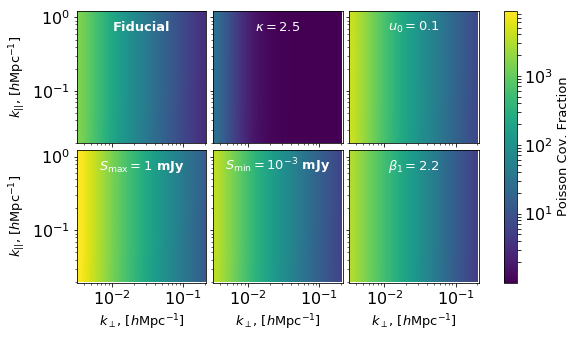

In [34]:
fig = make_ratio_plot(PS)
#fig.savefig("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/figures/compare_ratios_PS.pdf")
plt.show()

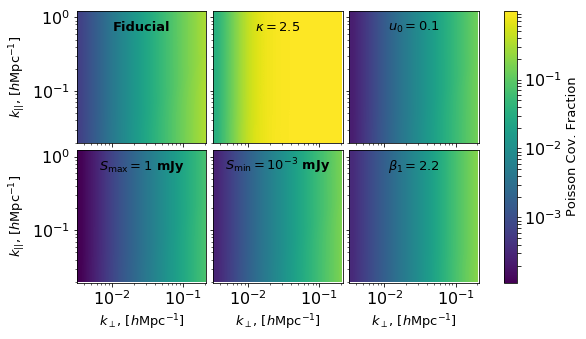

In [96]:
fig = make_ratio_plot(PS_b,True,cl='k')
fig.savefig("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/figures/compare_ratios_bias_PS.pdf")
plt.show()

## Realistic Power Spectrum

In this section, we attempt to derive a realistic power spectrum. We use the angular power spectrum of Blake+2008, $C_l = 2\times 10^{-4} l^{-1.2}$, and from it derive an approximate power spectrum in $u,v$, fitting a power-law power spectrum form to the result/.

In [9]:
from healpy import sphtfunc
from healpy import visufunc
from healpy import pixelfunc
from scipy.interpolate import griddata
from scipy.stats import linregress
from powerbox.tools import get_power

In [10]:
## Set up grid of l, and C.
l = np.arange(1,1000)
cls = 2e-4 * l**-1.2

# Generate the map from cls.
clmap = sphtfunc.synfast(cls,64)

# Find co-latitude and longitude of map pixels.
theta, phi = pixelfunc.pix2ang(64,np.arange(12*64**2))

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/home/steven/anaconda2/lib/python2.7/site-packages/healpy/sphtfunc.py:296: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning)


In [11]:
# Restrict map to a single hemisphere.
clmap_hemi = clmap[theta<=np.pi/2]
phi = phi[theta<=np.pi/2]
theta = theta[theta<=np.pi/2]

In [12]:
# Generate semi-Euclidean l, m co-ordinates
l = np.sin(theta)*np.cos(phi)
m = np.sin(theta)*np.sin(phi)

In [13]:
# Generate a uniform l,m grid. Only go up to 1/sqrt(2), so that the square stays within the circle.
lgrid = np.linspace(-1/np.sqrt(2),1/np.sqrt(2),3000)
L,M = np.meshgrid(lgrid,lgrid)

# Interpolate map onto the uniform grid.
interp_map = griddata(np.array([l,m]).T,clmap_hemi, (L,M))
interp_map[np.isnan(interp_map)] = np.nanmean(interp_map)

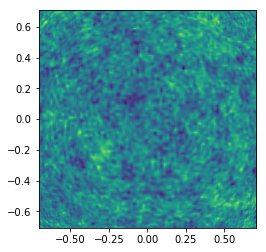

In [14]:
# Make a plot of the map
plt.imshow(interp_map,extent=[-1/np.sqrt(2),1/np.sqrt(2),-1/np.sqrt(2),1/np.sqrt(2)])

In [15]:
# Generate the power spectrum of the map
pk, k = get_power(interp_map,2/np.sqrt(2))

In [16]:
# Find the slope and intercept of the resulting power spectrum
slope, intercept, _,_,_ = linregress(np.log(k), np.log(pk))
print slope, intercept

# Find u0 and kappa from slope and intercept
u0= np.exp(-intercept/slope)
kappa = -slope
print u0, kappa

-4.36424268032 6.27302463789
4.20960335094 4.36424268032


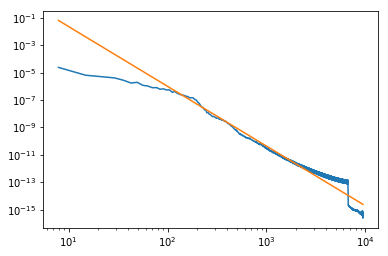

In [17]:
# Compare power-law fit to actual power-spectrum. We really only trust smaller scales.
plt.plot(k,pk)
plt.plot(k,(k/u0)**-kappa)
plt.xscale('log')
plt.yscale('log')

### Plot 2D PS

In [14]:
def plot_2D_PS_frac_tot(ps1, ps2, kperp, kpar, make_label=True, fig=None, ax=None, interp=None, lognorm=True):
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(9,4), sharex=True, sharey=True,
                               subplot_kw={"xscale": 'log', "yscale": 'log'})

    if lognorm:
        norm = LogNorm(vmin=1)
    else:
        norm = None

    PS1 = getattr(ps1, "value", ps1)
    PS2 = getattr(ps2, "value", ps2)

    KPERP = getattr(kperp, "value", kperp)
    KPAR = getattr(kpar, "value", kpar)

    cax1 = ax[0].imshow(PS1/PS2, origin="lower", #norm=norm,
                        aspect='auto', extent=(KPERP.min(), KPERP.max(), KPAR.min(), KPAR.max()),
                        interpolation=interp)
    cax2 = ax[1].imshow(PS2, origin="lower", norm=LogNorm(),
                        aspect='auto', extent=(KPERP.min(), KPERP.max(), KPAR.min(), KPAR.max()),
                        interpolation=interp)

    cbar1 = fig.colorbar(cax1, ax=ax[0])
    cbar2 = fig.colorbar(cax2, ax=ax[1])

    if make_label:
        ax[0].text(0.5, 0.93, "Clustering Fraction", transform=ax[0].transAxes, fontsize=14, fontweight='bold', color='white',
                   ha='center')
        ax[1].text(0.5, 0.93, "Total Power", transform=ax[1].transAxes, fontsize=14, fontweight='bold', color='white',
                   ha="center")

        # colax1.set_ylabel(r"Power Ratio", fontsize=13)
        # colax1.yaxis.set_label_position("right")

        cbar2.ax.set_ylabel(r"${\rm mK}^2 h^{-3}{\rm Mpc}^3$", fontsize=13)
        cbar1.ax.set_ylabel("Ratio")

        ax[0].set_xlabel(r"$k_{\perp}$, $[h{\rm Mpc}^{-1}]$", fontsize=13)
        ax[1].set_xlabel(r"$k_{\perp}$, $[h{\rm Mpc}^{-1}]$", fontsize=13)
        ax[0].set_ylabel(r"$k_{||}$, $[h{\rm Mpc}^{-1}]$", fontsize=13)

    plt.tight_layout()
    return fig, ax

In [48]:
# Plot the 2D PS resulting from this source distribution

nu = np.linspace(1,180./150.,128)

model_mwa = CircularGaussianPowerLaw(source_counts=MultiPowerLawSourceCounts(nu=nu,Smax0=0.03,Smin0=1e-4,alpha=6998.,beta=[1.54,1.95],Sbreak=[0.006]), 
                                 beam_model=CircularGaussian(150.,nu=nu),
                                 u =np.linspace(10.,200.0,200),
                                 clustering_params={"u0":u0,"kappa":kappa})

model_ska = CircularGaussianPowerLaw(source_counts=MultiPowerLawSourceCounts(nu=nu,Smax0=0.001,Smin0=1e-4,alpha=6998.,beta=[1.54,1.95],Sbreak=[0.006]), 
                                 beam_model=CircularGaussian(150.,nu=nu,D=35),
                                 u =np.linspace(50.,750.0,300),
                                 clustering_params={"u0":u0,"kappa":kappa})

total_ps_mwa,kpar_mwa,kperp_mwa = model_mwa.power_spec_2d(20.)
clust_ps_mwa = model_mwa.power_spec_2d_clustering(20.)[0]
total_ps_ska,kpar_ska,kperp_ska = model_ska.power_spec_2d(20.)
clust_ps_ska = model_ska.power_spec_2d_clustering(20.)[0]


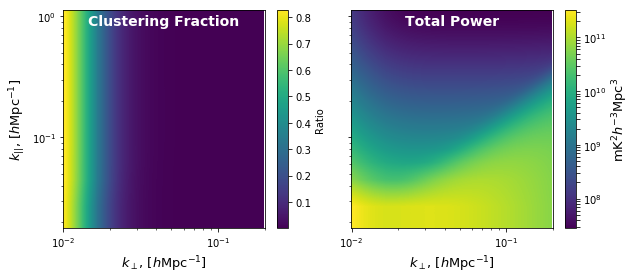

In [43]:
plot_2D_PS_frac_tot(clust_ps_mwa,total_ps_mwa,kperp_mwa,kpar_mwa,interp="bilinear",lognorm=False)
plt.savefig("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/figures/compare_realistic_PS_mwa.pdf")
plt.show()

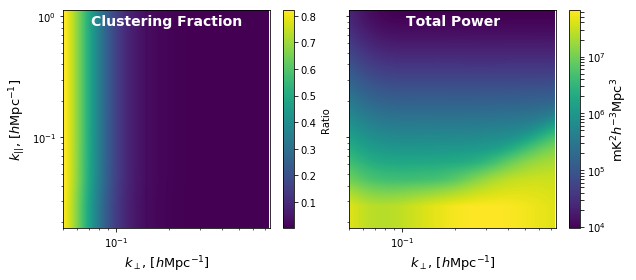

In [49]:
plot_2D_PS_frac_tot(clust_ps_ska,total_ps_ska,kperp_ska,kpar_ska,interp="bilinear",lognorm=False)
plt.savefig("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/figures/compare_realistic_PS_ska.pdf")
plt.show()

## Connect To Instruments

In [2]:
# Manually set point-source power spectrum parameters from previous section 
u0_obs,kappa_obs = 4.14, 4.36

### Check large-u approx

15.4475961884 1 / rad 70.0769130884 1 / rad


/home/steven/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in multiply
/home/steven/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in divide


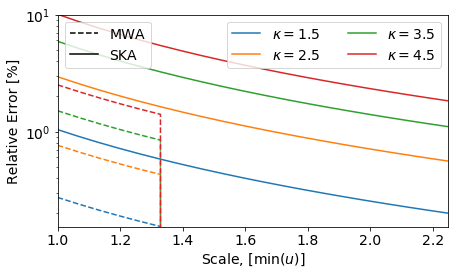

In [19]:
from spore.model.foregrounds import exp_hyp1f1, hyp1f1, gamma
from spore.mock.convert_sim_to_vis import pos_to_baselines

mpl.rcParams['font.size'] = 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

baselines_mwa = pos_to_baselines(np.genfromtxt("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/hex_pos.txt")[:,1:])
baselines_ska = pos_to_baselines(np.genfromtxt("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/SKA_Low_v5_ENU_fullcore.txt"))


mwa_min = np.sqrt(baselines_mwa[:,0]**2 + baselines_mwa[:,1]**2).min() * 2. / un.rad
ska_min = np.sqrt(baselines_ska[:,0]**2 + baselines_ska[:,1]**2).min() * 2. / un.rad

print mwa_min, ska_min

mwa_beam = CircularGaussian(nu=1,nu0=150., D=4.)
ska_beam = CircularGaussian(nu=1,nu0=150., D=35.)

plt.figure(figsize=(7,3.9))
lines = [0]*4
for i,(mn,s) in enumerate(zip([mwa_min,ska_min],[mwa_beam.sigma[0],ska_beam.sigma[0]])):
    for j,kp in enumerate(np.array([1.5,2.5,3.5,4.5])): 
        y = 2*np.pi*s**2
        alph = 1-kp/2
        q = 1

        a = 2*np.pi*y
        b = alph
        c = 1
        d = np.pi*y*q
        x = (np.linspace(1,2.25,20)*mn)**2

        d = d.value
        x = x.value
        a = a.value
        
        wrong_by = gamma(b)*np.exp(-a*x)*hyp1f1(b, c, d*x)/( np.exp(d*x - a*x)*(d*x) ** (b - c))-1
        lines[j], = plt.plot(np.linspace(1,2.25,20),100*wrong_by,label="$\kappa=%s$"%kp if i else None,ls='--' if not i else '-',color="C%s"%j)
    
mwa_line, = plt.plot([0],[0],label="MWA",ls='--',color='k')
ska_line, = plt.plot([0],[0],label="SKA",ls='-',color='k')

leg1 = plt.legend(handles=lines,ncol=2)
ax = plt.gca().add_artist(leg1)

plt.legend(handles=[mwa_line,ska_line],loc='upper left')

plt.yscale('log')
plt.xlabel("Scale, [min($u$)]")
plt.ylabel("Relative Error [%]")
plt.ylim(0,10.)
plt.xlim(1,2.25)

plt.savefig("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/figures/approximation_error.pdf")

### Get Power Spectrum from Basic Box

In [20]:
pk_2d, kperp, kpar, simdat = pssim.get_power_lightcone("/home/steven/Documents/Projects/Foregrounds/delta_T_v3_no_halos__zstart005.00000_zend009.56801_FLIPBOXES0_1024_1600Mpc_lighttravel", 
                                               get_delta=False, res_ndim=2, taper=blackmanharris)

pk_1d, kav_1d = pssim.get_power_lightcone("/home/steven/Documents/Projects/Foregrounds/delta_T_v3_no_halos__zstart005.00000_zend009.56801_FLIPBOXES0_1024_1600Mpc_lighttravel", taper=blackmanharris)

thisnu = np.linspace(1,simdat['nu'].max()/simdat['nu'].min(),len(simdat['nu']))
thisu = Planck15.h*Planck15.comoving_distance(simdat['z'].min()) * kperp/(2*np.pi)

{'dim': 1024, 'BoxSize': 1600, 'basedir': '/home/steven/Documents/Projects/Foregrounds', 'HIIdim': 1024, 'filename': 'delta_T_v3_no_halos__zstart005.00000_zend009.56801_FLIPBOXES0_1024_1600Mpc_lighttravel', 'z': 0.0, 'type': 'deltaT'}


/home/steven/anaconda2/lib/python2.7/site-packages/spore/mock/convert_sim_to_vis.py:71: RuntimeWarning: invalid value encountered in greater
  mask = np.logical_and(nu > numin, nu < numax)
/home/steven/anaconda2/lib/python2.7/site-packages/spore/mock/convert_sim_to_vis.py:71: RuntimeWarning: invalid value encountered in less
  mask = np.logical_and(nu > numin, nu < numax)


{'dim': 1024, 'BoxSize': 1600, 'basedir': '/home/steven/Documents/Projects/Foregrounds', 'HIIdim': 1024, 'filename': 'delta_T_v3_no_halos__zstart005.00000_zend009.56801_FLIPBOXES0_1024_1600Mpc_lighttravel', 'z': 0.0, 'type': 'deltaT'}


(<matplotlib.figure.Figure at 0x7f2c58637b10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2c58960b10>)

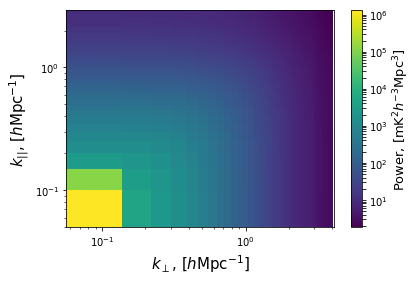

In [69]:
plot_2D_PS(pk_2d.T,kperp,kpar)

In [21]:
# 1D PS from 2D
kcoords = np.sqrt(np.add.outer(kperp**2, kpar**2)).T
mean_signal_true, kbins_true = angular_average(pk_2d.T, kcoords, bins=50)

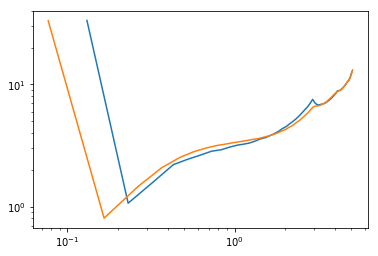

In [6]:
# Just to make sure we're averaging down correctly
plt.plot(kbins_true,mean_signal_true * kbins_true**3/(2*np.pi**2))
plt.plot(kav_1d,pk_1d)
plt.xscale('log')
plt.yscale('log')

### Covariance Model For Each Instrument

In [3]:


def average_to_1d(kperp,kpar,power, power_cov,bins=15):
    # Average to 1D
    kcoords = np.sqrt(np.add.outer(kperp**2, kpar**2)).T
    weights = 1./power_cov

    mean_signal, kbins = angular_average(pk_2d.T + power.value, kcoords, bins=bins, weights = weights)
    variance = 1/angular_average(1./power_cov, kcoords, bins=bins)[0]
    return kbins, mean_signal, variance
    
def make_models(Smin,beta1,u0,kappa, thisnu,thisu):
    
    # MWA
    model_mwa = CircularGaussianPowerLaw(source_counts=MultiPowerLawSourceCounts(nu=thisnu,Smax0=3e-2,Smin0=Smin,alpha=6998.,beta=[1.54,beta1],
                                                                                  Sbreak=[0.006]), 
                                      beam_model=CircularGaussian(150.,nu=thisnu),
                                      u =thisu.value,
                                      clustering_params={"u0":u0 ,"kappa":kappa})

    total_ps_mwa = model_mwa.power_cov_total(blackmanharris)
    poiss_ps_mwa = model_mwa.power_cov_poisson(blackmanharris)


    # SKA
    model_ska = CircularGaussianPowerLaw(source_counts=PowerLawSourceCounts(nu=thisnu,Smax0=1e-3,Smin0=Smin,alpha=237.9,beta=beta1), 
                                      beam_model=CircularGaussian(150.,nu=thisnu, D = 35.),
                                      u =thisu.value,
                                      clustering_params={"u0":u0 ,"kappa":kappa})

    total_ps_ska = model_ska.power_cov_total(blackmanharris)
    poiss_ps_ska = model_ska.power_cov_poisson(blackmanharris)

    k_1d, full_signal_mwa, total_variance_mwa = average_to_1d(model_mwa.kperp.value, model_mwa.kpar.value, np.sqrt(total_ps_mwa), total_ps_mwa, bins=15)
    k_1d, pois_signal_mwa, poiss_variance_mwa = average_to_1d(model_mwa.kperp.value, model_mwa.kpar.value, np.sqrt(total_ps_mwa), poiss_ps_mwa, bins=15)
    
    k_1d, full_signal_ska, total_variance_ska = average_to_1d(model_ska.kperp.value, model_ska.kpar.value, np.sqrt(total_ps_ska), total_ps_ska, bins=15)
    k_1d, pois_signal_ska, poiss_variance_ska = average_to_1d(model_ska.kperp.value, model_ska.kpar.value, np.sqrt(total_ps_ska), poiss_ps_ska, bins=15)
    
    return ({"mwa_t":total_ps_mwa, "mwa_p":poiss_ps_mwa, "ska_t":total_ps_ska, "ska_p":poiss_ps_ska}, {"mwa":model_mwa, "ska":model_ska}, k_1d,
           {"mwa_t":full_signal_mwa, "mwa_p":pois_signal_mwa, "ska_t":full_signal_ska, "ska_p":pois_signal_ska},
           {"mwa_t":total_variance_mwa, "mwa_p":poiss_variance_mwa,"ska_t":total_variance_ska,"ska_p":poiss_variance_ska})
    

def make_1d_plot_ax(kbins_true, mean_signal_true, k_1d, signal, variance, fig=None,ax=None, plt_labels=True):
    if fig is None and ax is None:
        fig, ax = plt.subplots(1,1,figsize=(8,5))
        
    ax.plot(kbins_true[1:],mean_signal_true[1:]*kbins_true[1:]**3/(2*np.pi**2),label="Noise-Free Model")
    ax.errorbar(k_1d[1:],signal['mwa_t'][1:]*k_1d[1:]**3/(2*np.pi**2), 
                 yerr=np.sqrt(variance['mwa_t'][1:]) * k_1d[1:]**3/(2*np.pi**2),ls="",marker='o', label="MWA Full")
    ax.errorbar(k_1d[1:]*1.02,signal['mwa_p'][1:]*k_1d[1:]**3/(2*np.pi**2), 
                 yerr=np.sqrt(variance['mwa_p'][1:]) * k_1d[1:]**3/(2*np.pi**2),ls="",marker='o', label="MWA Poisson")
    ax.errorbar(k_1d[1:]*0.98,signal['ska_t'][1:]*k_1d[1:]**3/(2*np.pi**2), 
                 yerr=np.sqrt(variance['ska_t'][1:]) * k_1d[1:]**3/(2*np.pi**2),ls="",marker='o', label="SKA Full")
    ax.errorbar(k_1d[1:]*0.96,signal['ska_p'][1:]*k_1d[1:]**3/(2*np.pi**2), 
                 yerr=np.sqrt(variance['ska_p'][1:]) * k_1d[1:]**3/(2*np.pi**2),ls="",marker='o', label="SKA Poisson")

    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(0.8,180)
    ax.set_xlim(0.4,)

    if plt_labels:
        ax.set_xlabel("$k, [h/\mathrm{Mpc}]$", fontsize=15)
        ax.set_ylabel("$\Delta^2$",fontsize=15)
        ax.legend(loc='best')

    return fig, ax


    

#### Fiducial

In [101]:
fid_pc, fid_models, fid_k_1d, fid_signal, fid_variance = make_models(1e-4,1.95,u0_obs,kappa_obs,thisnu,thisu)

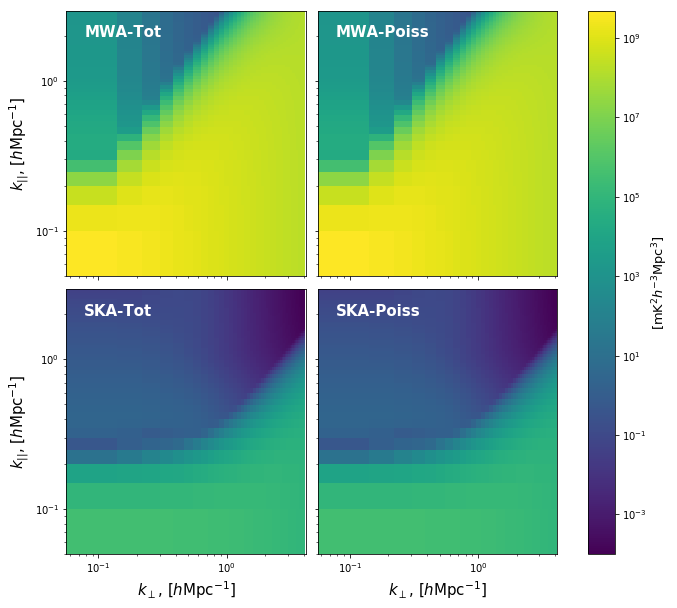

In [63]:
fig,ax = plot_2D_PS_compare([[np.sqrt(fid_pc['mwa_t']),np.sqrt(fid_pc['ska_t'])],
                             [np.sqrt(fid_pc['mwa_p']),np.sqrt(fid_pc['ska_p'])]],
                            kperp,kpar,
                            plt_labels=[["MWA-Tot", "SKA-Tot"],
                                        ["MWA-Poiss","SKA-Poiss"]])

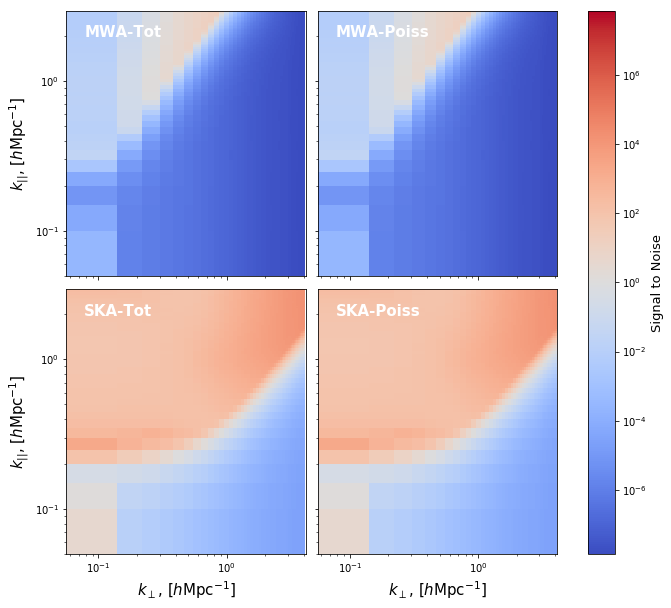

In [71]:
fig,ax = plot_sig_to_noise_compare([[pk_2d.T/np.sqrt(fid_pc['mwa_t']),pk_2d.T/np.sqrt(fid_pc['ska_t'])],
                                    [pk_2d.T/np.sqrt(fid_pc['mwa_p']),pk_2d.T/np.sqrt(fid_pc['ska_p'])]],
                                   kperp,kpar,plt_labels=[["MWA-Tot", "SKA-Tot"],["MWA-Poiss","SKA-Poiss"]])
fig.savefig("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/figures/signal_to_noise_fiducial.pdf")
fig.savefig("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/figures/signal_to_noise_fiducial.png")

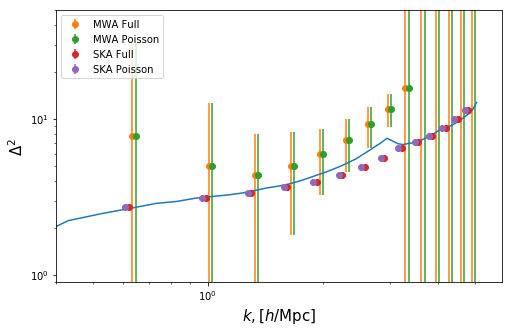

In [119]:
fig,ax = make_1d_plot_ax(kbins_true,mean_signal_true, fid_k_1d, fid_signal, fid_variance)

#### Low kappa (my actual fiducial)

In [36]:
lk_pc, lk_models, lk_k_1d, lk_signal, lk_variance = make_models(1e-4,1.95,0.05,1.5,thisnu,thisu)

1 / sr sr
1 / sr sr


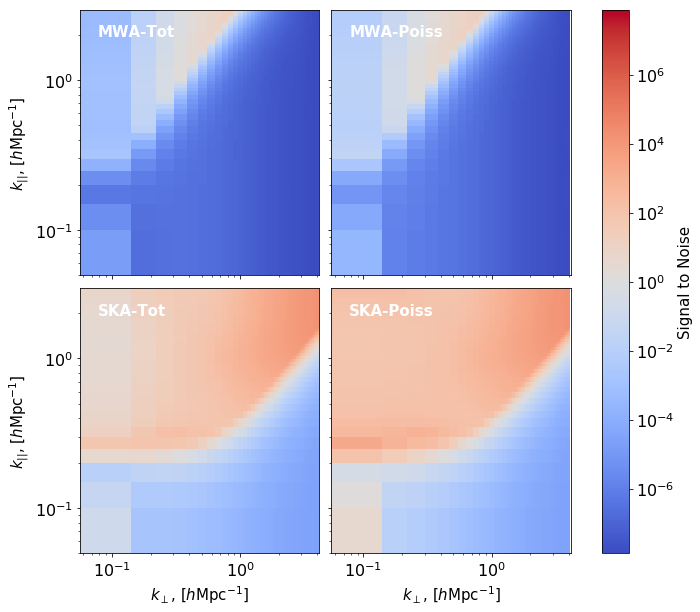

In [37]:
mpl.rcParams['font.size'] = 15
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16

fig,ax = plot_sig_to_noise_compare([[pk_2d.T/np.sqrt(lk_pc['mwa_t']),pk_2d.T/np.sqrt(lk_pc['ska_t'])],
                                    [pk_2d.T/np.sqrt(lk_pc['mwa_p']),pk_2d.T/np.sqrt(lk_pc['ska_p'])]],
                                   kperp,kpar,plt_labels=[["MWA-Tot", "SKA-Tot"],["MWA-Poiss","SKA-Poiss"]])
fig.savefig("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/figures/signal_to_noise_low_kappa.pdf")

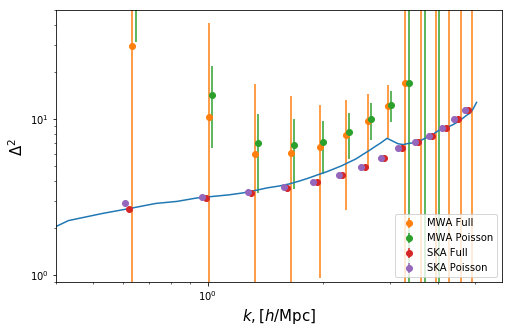

In [135]:
fig,ax = make_1d_plot_ax(kbins_true,mean_signal_true, lk_k_1d, lk_signal, lk_variance)
plt.savefig("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/figures/final_1d_plot_lk.pdf")
plt.savefig("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/figures/final_1d_plot_lk.png")

#### low smin

In [38]:
ls_pc, ls_models, ls_k_1d, ls_signal, ls_variance = make_models(1e-6,1.95,0.05,1.5,thisnu,thisu)

1 / sr sr
1 / sr sr


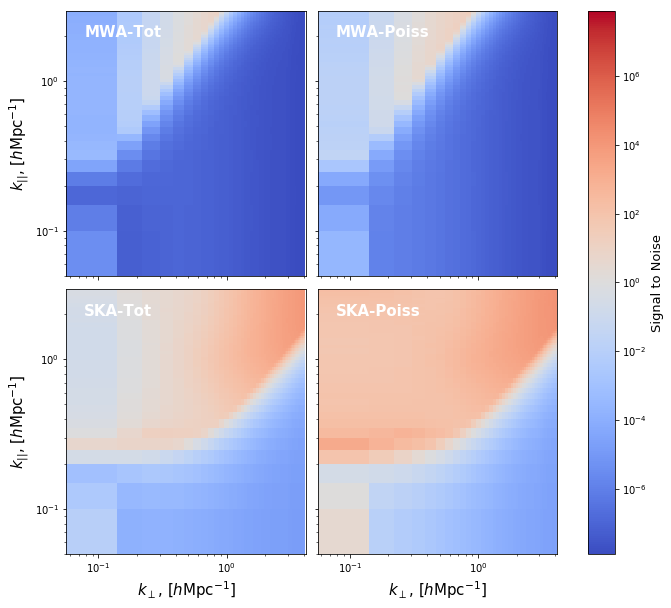

In [137]:
fig,ax = plot_sig_to_noise_compare([[pk_2d.T/np.sqrt(ls_pc['mwa_t']),pk_2d.T/np.sqrt(ls_pc['ska_t'])],
                                    [pk_2d.T/np.sqrt(ls_pc['mwa_p']),pk_2d.T/np.sqrt(ls_pc['ska_p'])]],
                                   kperp,kpar,plt_labels=[["MWA-Tot", "SKA-Tot"],["MWA-Poiss","SKA-Poiss"]])
fig.savefig("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/figures/signal_to_noise_low_smin.pdf")
fig.savefig("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/figures/signal_to_noise_low_smin.png")

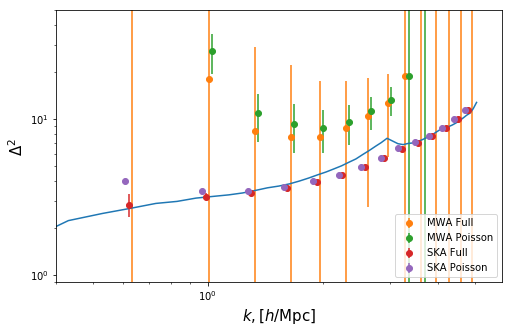

In [138]:
fig,ax = make_1d_plot_ax(kbins_true,mean_signal_true, ls_k_1d, ls_signal, ls_variance)
plt.savefig("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/figures/final_1d_plot_ls.pdf")
plt.savefig("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/figures/final_1d_plot_ls.png")

#### Higher kappa

1 / sr sr
1 / sr sr


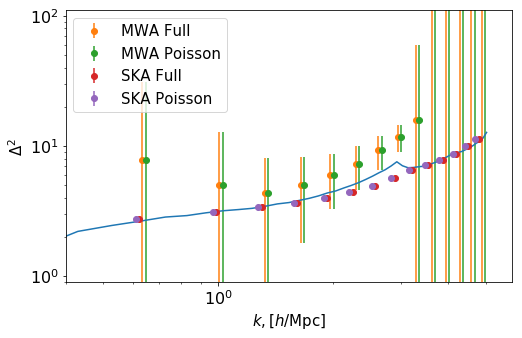

In [39]:
hk_pc, hk_models, hk_k_1d, hk_signal, hk_variance = make_models(1e-4,1.95,0.05,2.5,thisnu,thisu)

fig,ax = make_1d_plot_ax(kbins_true,mean_signal_true, hk_k_1d, hk_signal, hk_variance)
plt.savefig("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/figures/final_1d_plot_hk.pdf")
plt.savefig("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/figures/final_1d_plot_hk.png")

#### Higher beta1

1 / sr sr
1 / sr sr


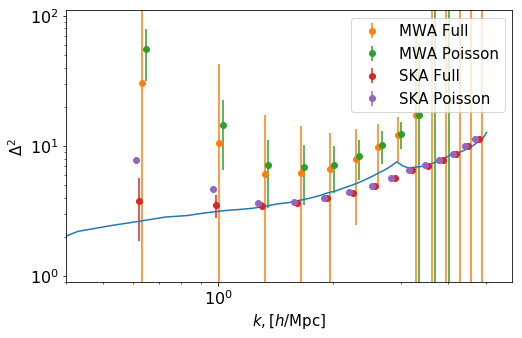

In [40]:
hb_pc, hb_models, hb_k_1d, hb_signal, hb_variance = make_models(1e-4,2.2,0.05,1.5,thisnu,thisu)

fig,ax = make_1d_plot_ax(kbins_true,mean_signal_true, hb_k_1d, hb_signal, hb_variance)
plt.savefig("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/figures/final_1d_plot_hb.pdf")
plt.savefig("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/figures/final_1d_plot_hb.png")

#### Higher u0

1 / sr sr
1 / sr sr


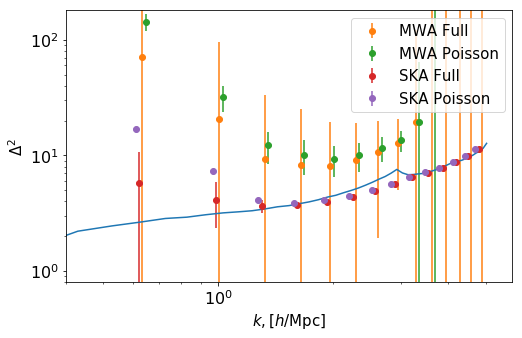

In [49]:
hu_pc, hu_models, hu_k_1d, hu_signal, hu_variance = make_models(1e-4,2.2,0.1,1.5,thisnu,thisu)

fig,ax = make_1d_plot_ax(kbins_true,mean_signal_true, hu_k_1d, hu_signal, hu_variance)
plt.savefig("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/figures/final_1d_plot_hu.pdf")

#### Plot all 1D plots together

In [94]:
def make_1d_plots(kbins_true,mean_signal_true, k_1d, signal, variance, labels):
    fig, ax = plt.subplots(2,3, sharex=True, sharey=True, gridspec_kw={"hspace":0, 'wspace':0}, 
                           figsize=(12,7),subplot_kw={"ylim":(0.8,200)})
    
    print ax.shape, len(signal)
    for i in range(3):
        for j in range(2):
            if i==2 and j==0:
                ax[j,i].axis("off")
            else:
                fig, ax[j,i] = make_1d_plot_ax(kbins_true,mean_signal_true, k_1d[i][j], signal[i][j], variance[i][j],fig=fig,ax=ax[j,i],plt_labels=False)
                ax[j,i].text(1.,100,labels[i][j], fontsize=15, fontweight='bold')

                if i==0:
                    ax[j,i].set_ylabel("$\Delta^2$",fontsize=15)
                if j==1:
                    ax[j,i].set_xlabel("$k,\ \ [h/\mathrm{Mpc}]$",fontsize=15)
                
    ax[1,0].legend(bbox_to_anchor=(0.885, 0.85),
                   bbox_transform=plt.gcf().transFigure)
    return fig, ax
            

(2, 3) 3


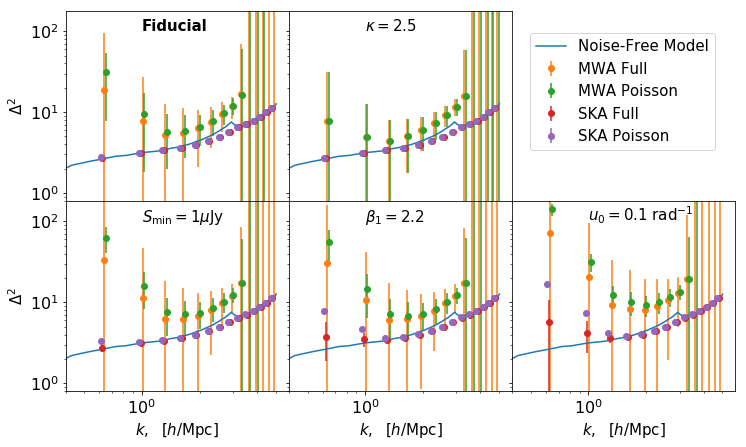

In [95]:
make_1d_plots(kbins_true,mean_signal_true, [[lk_k_1d, ls_k_1d],[hk_k_1d,hb_k_1d],[None,hu_k_1d]], [[lk_signal, ls_signal],[hk_signal,hb_signal],[None,hu_signal]],
              [[lk_variance, ls_variance],[hk_variance,hb_variance],[None,hu_variance]], labels=[["Fiducial", r"$S_\mathrm{min} = 1\mu \mathrm{Jy}$"],[r"$\kappa=2.5$", r"$\beta_1 = 2.2$"],[None,r"$u_0 = 0.1 \ \mathrm{rad}^{-1}$"]])

plt.savefig("/home/steven/Documents/Projects/Foregrounds/clustering_counts_paper/figures/final_1d_plots_panels.pdf")

## Test of Simplest Model vs. CHIPS

This section is only meant for directly testing against CHIPS' output, to make sure things are working smoothly.

In [8]:
sc = PowerLawSourceCounts(nu=np.linspace(1,(180./150.),128),Smax0=1e0,Smin0=0,alpha=4100.,beta=1.59)


model_simple = PointSourceCircularGaussian(source_counts=sc,
                                  beam_model=CircularGaussian(150.,nu=np.linspace(1,(180./150.),128)),
                                  u =np.linspace(5,300.,250),
                                  clustering_params=None)


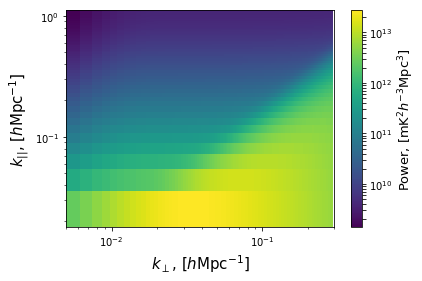

(<matplotlib.figure.Figure at 0x7f6f97446490>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f6f9799f7d0>)

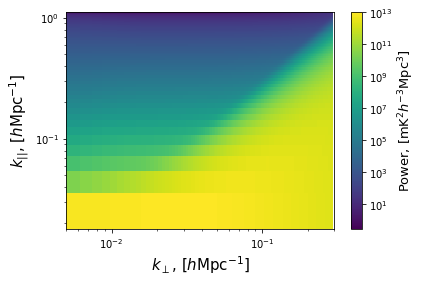

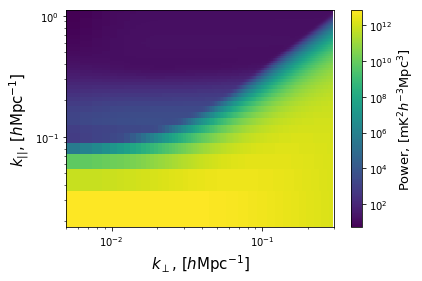

In [10]:
out,kpar,kperp = model_simple.power_spec_2d_poisson(20.)
plot_2D_PS(out,kperp,kpar)
plt.show()

out,kpar,kperp = model_simple.power_spec_2d_poisson(20.,window=np.hanning)
plot_2D_PS(out,kperp,kpar)

out,kpar,kperp = model_simple.power_spec_2d_poisson(20.,window=blackmanharris)
plot_2D_PS(out,kperp,kpar)
